In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import re # for regex
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from tensorflow.keras.datasets import imdb

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Embedding, Conv1D,Input, GlobalMaxPooling1D,MaxPooling1D, Dense, Dropout,Activation

# Load data|
data = pd.read_csv('imdb_master.csv', encoding='ISO-8859-1')


In [2]:
data = pd.read_csv('IMDB-Dataset.csv',encoding='ISO-8859-1')
print(data.shape)
data.head()

(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [4]:
data.sentiment.value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

In [5]:
data.sentiment.replace('positive',1,inplace=True)
data.sentiment.replace('negative',0,inplace=True)
data.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
5,"Probably my all-time favorite movie, a story o...",1
6,I sure would like to see a resurrection of a u...,1
7,"This show was an amazing, fresh & innovative i...",0
8,Encouraged by the positive comments about this...,0
9,If you like original gut wrenching laughter yo...,1


In [6]:
data.review[0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

1. Remove HTML tags

In [7]:
def clean(text):
    cleaned = re.compile(r'<.*?>')
    return re.sub(cleaned,'',text)

data.review = data.review.apply(clean)
data.review[0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.I would say the main appeal of the show is due to the fact that it goes where other shows wo

2. Remove special characters

In [8]:
def is_special(text):
    rem = ''
    for i in text:
        if i.isalnum():
            rem = rem + i
        else:
            rem = rem + ' '
    return rem

data.review = data.review.apply(is_special)
data.review[0]

'One of the other reviewers has mentioned that after watching just 1 Oz episode you ll be hooked  They are right  as this is exactly what happened with me The first thing that struck me about Oz was its brutality and unflinching scenes of violence  which set in right from the word GO  Trust me  this is not a show for the faint hearted or timid  This show pulls no punches with regards to drugs  sex or violence  Its is hardcore  in the classic use of the word It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary  It focuses mainly on Emerald City  an experimental section of the prison where all the cells have glass fronts and face inwards  so privacy is not high on the agenda  Em City is home to many  Aryans  Muslims  gangstas  Latinos  Christians  Italians  Irish and more    so scuffles  death stares  dodgy dealings and shady agreements are never far away I would say the main appeal of the show is due to the fact that it goes where other shows wo

3. Convert everything to lowercase

In [9]:
def to_lower(text):
    return text.lower()

data.review = data.review.apply(to_lower)
data.review[0]

'one of the other reviewers has mentioned that after watching just 1 oz episode you ll be hooked  they are right  as this is exactly what happened with me the first thing that struck me about oz was its brutality and unflinching scenes of violence  which set in right from the word go  trust me  this is not a show for the faint hearted or timid  this show pulls no punches with regards to drugs  sex or violence  its is hardcore  in the classic use of the word it is called oz as that is the nickname given to the oswald maximum security state penitentary  it focuses mainly on emerald city  an experimental section of the prison where all the cells have glass fronts and face inwards  so privacy is not high on the agenda  em city is home to many  aryans  muslims  gangstas  latinos  christians  italians  irish and more    so scuffles  death stares  dodgy dealings and shady agreements are never far away i would say the main appeal of the show is due to the fact that it goes where other shows wo

4. Remove stopwords

In [10]:
def rem_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    return [w for w in words if w not in stop_words]

data.review = data.review.apply(rem_stopwords)


5. Stem the words

In [11]:
def stem_txt(text):
    ss = SnowballStemmer('english')
    return " ".join([ss.stem(w) for w in text])

data.review = data.review.apply(stem_txt)
data.review[0]

'one review mention watch 1 oz episod hook right exact happen first thing struck oz brutal unflinch scene violenc set right word go trust show faint heart timid show pull punch regard drug sex violenc hardcor classic use word call oz nicknam given oswald maximum secur state penitentari focus main emerald citi experiment section prison cell glass front face inward privaci high agenda em citi home mani aryan muslim gangsta latino christian italian irish scuffl death stare dodgi deal shadi agreement never far away would say main appeal show due fact goe show dare forget pretti pictur paint mainstream audienc forget charm forget romanc oz mess around first episod ever saw struck nasti surreal say readi watch develop tast oz got accustom high level graphic violenc violenc injustic crook guard sold nickel inmat kill order get away well manner middl class inmat turn prison bitch due lack street skill prison experi watch oz may becom comfort uncomfort view that get touch darker side'

1. Creating Bag Of Words (BOW)

In [12]:
X = np.array(data.iloc[:,0].values)
y = np.array(data.sentiment.values)
# cv = CountVectorizer(max_features = 1000)
# X = cv.fit_transform(data.review).toarray()
print("X.shape = ",X.shape)
print("y.shape = ",y.shape)

X.shape =  (50000,)
y.shape =  (50000,)


2. Train Test Split

In [13]:
trainx,remx,trainy,remy = train_test_split(X,y, train_size=0.8)

# Now since we want the valid and test size to be equal (10% each of overall data). 
# we have to define valid_size=0.5 (that is 50% of remaining data)
test_size = 0.5
valx, testx, valy, testy = train_test_split(remx,remy, test_size=0.5)


print("Train shapes : X = {}, y = {}".format(trainx.shape,trainy.shape))
print("Test shapes : X = {}, y = {}".format(testx.shape,testy.shape))
print("Validation shapes : X = {}, y = {}".format(valx.shape,valy.shape))

Train shapes : X = (40000,), y = (40000,)
Test shapes : X = (5000,), y = (5000,)
Validation shapes : X = (5000,), y = (5000,)


In [14]:
trainx

array(['hint number one read titl time mad dog perhap dog pretti good ensembl piec look cast rent know curious alreadi first time director bishop give chanc take time let charact interact chew sceneri wait enthusiast return big boss whatev reveng ensu us highlight see christoph jone self impos exil film remain command film presenc yes christoph jone larri bishop richard pryor involv wild street reunion parti',
       'think usual approach film festiv comedi low expect invari quirki intend humor deriv sole expens charact simplic face complic context except big bad swim director abl maintain integr develop charact film still find laugh loud humor scene scene sophist mayb due also part sharp work dp rare seen indi film even rare comedi special note paget brewster turn ami math teacher see perform understand brewster discov larger audienc bring necessari mix anger likabl role realli help pictur reach potenti terrif work deserv larger audienc look forward director cast',
       'thought mov

In [17]:
from tensorflow.keras.preprocessing.text import Tokenizer
max_words=10000
tokenizer=Tokenizer(max_words)
tokenizer.fit_on_texts(trainx)
sequence_train=tokenizer.texts_to_sequences(trainx)
sequence_test=tokenizer.texts_to_sequences(testx)
sequence_val=tokenizer.texts_to_sequences(valx)


In [16]:
word2vec=tokenizer.word_index
V=len(word2vec)
print('dataset has %s number of independent tokens' %V)

dataset has 66830 number of independent tokens


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
data_train=pad_sequences(sequence_train)
data_train.shape

(40000, 1288)

In [ ]:
T=data_train.shape[1]
data_test=pad_sequences(sequence_test,maxlen=T)
data_test.shape

(5000, 1288)

In [ ]:
T=data_train.shape[1]
data_val=pad_sequences(sequence_val,maxlen=T)
data_val.shape

(5000, 1288)

In [18]:
D=20
i=Input((T,))
x=Embedding(V+1,D)(i)
x=Conv1D(32,3,activation='relu')(x)
x=MaxPooling1D(3)(x)
x=Conv1D(64,3,activation='relu')(x)
x=MaxPooling1D(3)(x)
x=Conv1D(128,3,activation='relu')(x)
x=GlobalMaxPooling1D()(x)
x=Dense(5,activation='softmax')(x)
model=Model(i,x)
model.summary()

NameError: name 'T' is not defined

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
cnn_senti=model.fit(data_train,trainy,validation_data=(data_val,valy),epochs=10,batch_size=100)

Epoch 1/10
400/400 [==============================] - 9s 18ms/step - loss: 0.4698 - accuracy: 0.7649 - val_loss: 0.2887 - val_accuracy: 0.8796
Epoch 2/10
400/400 [==============================] - 7s 18ms/step - loss: 0.2396 - accuracy: 0.9058 - val_loss: 0.2773 - val_accuracy: 0.8848
Epoch 3/10
400/400 [==============================] - 7s 17ms/step - loss: 0.1770 - accuracy: 0.9333 - val_loss: 0.3102 - val_accuracy: 0.8754
Epoch 4/10
400/400 [==============================] - 7s 17ms/step - loss: 0.1231 - accuracy: 0.9571 - val_loss: 0.3604 - val_accuracy: 0.8736
Epoch 5/10
400/400 [==============================] - 7s 17ms/step - loss: 0.0691 - accuracy: 0.9779 - val_loss: 0.4643 - val_accuracy: 0.8658
Epoch 6/10
400/400 [==============================] - 7s 17ms/step - loss: 0.0315 - accuracy: 0.9912 - val_loss: 0.6116 - val_accuracy: 0.8654
Epoch 7/10
400/400 [==============================] - 7s 17ms/step - loss: 0.0125 - accuracy: 0.9970 - val_loss: 0.7881 - val_accuracy: 0.8634

In [ ]:
y_pred=model.predict(data_test)
y_pred

array([[1.00000000e+00, 4.29936003e-10, 2.91783153e-19, 5.28249979e-20,
        2.21661172e-20],
       [1.00000000e+00, 5.61439251e-09, 1.37971726e-26, 6.32685850e-28,
        4.10402912e-28],
       [2.52731240e-07, 9.99999762e-01, 1.14211167e-19, 1.52675779e-20,
        1.40134154e-20],
       ...,
       [1.06163396e-04, 9.99893785e-01, 5.29885335e-19, 5.09630241e-20,
        6.09910316e-20],
       [1.18172886e-06, 9.99998808e-01, 3.34019150e-20, 5.83570873e-21,
        3.37622532e-21],
       [3.31696391e-01, 6.68303549e-01, 8.43888544e-13, 1.86474561e-13,
        1.72599321e-13]], dtype=float32)

In [ ]:
y_pred=np.argmax(y_pred,axis=1)
y_pred

array([0, 0, 1, ..., 1, 1, 1], dtype=int64)

Text(50.722222222222214, 0.5, 'y_pred')

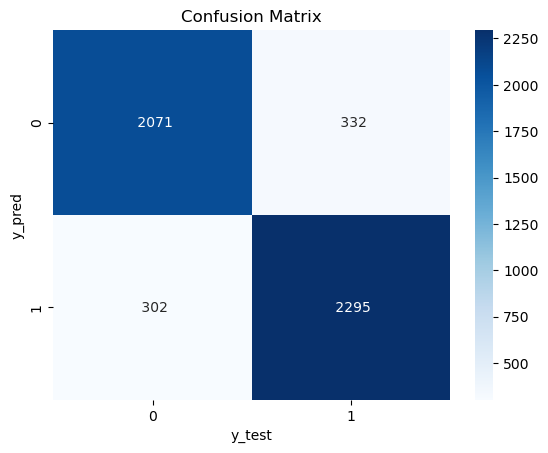

In [ ]:
cm=confusion_matrix(testy,y_pred)
print(cm)
ax=sns.heatmap(cm,annot=True,cmap='Blues',fmt=' ')
ax.set_title('Confusion Matrix')
ax.set_xlabel('y_test')
ax.set_ylabel('y_pred')

In [ ]:
print(classification_report(testy,y_pred))


              precision    recall  f1-score   support

           0       0.87      0.86      0.87      2403
           1       0.87      0.88      0.88      2597

    accuracy                           0.87      5000
   macro avg       0.87      0.87      0.87      5000
weighted avg       0.87      0.87      0.87      5000



In [ ]:
history_dict = cnn_senti.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

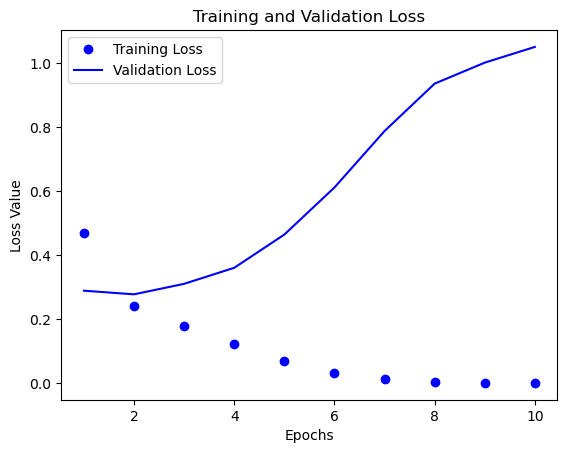

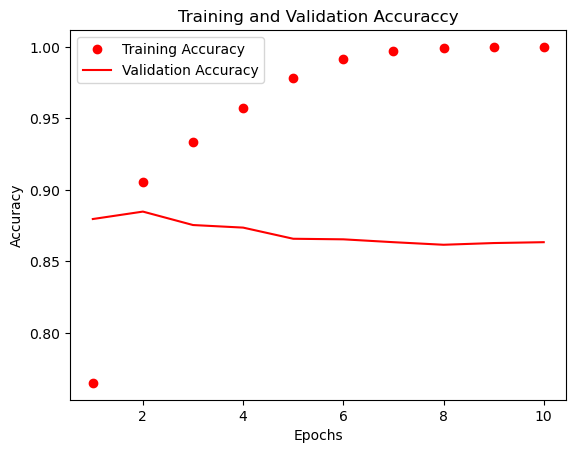

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
     

# Plotting losses
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo', label="Training Loss")
plt.plot(epochs, val_loss_values, 'b', label="Validation Loss")

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.legend()

plt.show()
     


# Training and Validation Accuracy

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, acc_values, 'ro', label="Training Accuracy")
plt.plot(epochs, val_acc_values, 'r', label="Validation Accuracy")

plt.title('Training and Validation Accuraccy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()
     